# AWS DeepRacerのためのシミュレーション実行ログの解析と可視化

このノートでは、AWS DeepRacer Simulationのログを使った分析とデバッグの方法を説明します。


1. モデルの最適なイテレーションを見つけるためのツール
1. 軌道上の報酬分布を可視化する
 - エピソードまたは反復ごとの報酬のヒートマップを可視化
1. 評価走行解析 - ラップスピードのヒートマップをプロット

In [1]:
!git clone https://github.com/aws-samples/aws-deepracer-workshops
!mv ./aws-deepracer-workshops/log-analysis/log_analysis.py .
!rm -fr aws-deepracer-workshops
# # !git clone https://github.com/aws-deepracer-community/deepracer-analysis
# # !mv ./deepracer-analysis/tracks .
# # !rm deepracer-analysis
!git clone https://github.com/haradatm/ad.git
!mv ad/deepracer/tracks .
!rm -fr ad

Cloning into 'aws-deepracer-workshops'...
remote: Enumerating objects: 3028, done.
remote: Total 3028 (delta 0), reused 0 (delta 0), pack-reused 3028
Receiving objects: 100% (3028/3028), 80.50 MiB | 5.15 MiB/s, done.
Resolving deltas: 100% (911/911), done.
on a case-insensitive filesystem) and only one from the same
colliding group is in the working tree:

  'Advanced workshops/reInvent2019-400/README.md'
  'Advanced workshops/reInvent2019-400/readme.md'
Cloning into 'ad'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 65 (delta 15), reused 61 (delta 11), pack-reused 0
Unpacking objects: 100% (65/65), 2.93 MiB | 2.28 MiB/s, done.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Markdown
# from markdown_helper import generate_s3_write_permission_for_sagemaker_role
# import sagemaker
# import boto3
# import shutil
import os
import glob
import math
%matplotlib inline

In [3]:
!pip install shapely

In [4]:
#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

In [5]:
from log_analysis import *
from os import listdir
from os.path import isfile, join
import warnings
warnings.filterwarnings('ignore')

## ログファイルを配置する

マネジメントコンソールからダウンロードしたログファイルを 'logs' ディレクトリ内に配置します。

In [6]:
# !tree logs

すべてのcsvファイルを1つの大きな.csvファイルに統合します。

In [7]:
merged_simtrace_path = "./logs/deepracer-{}.csv".format("training")

In [8]:
def get_sort_csv_file(tmp):
    sim_trace_csvs = glob.glob(os.path.join(tmp, "*.csv"))
    csvs_with_ids = [(int(os.path.basename(file).split("-")[0]), file) for file in sim_trace_csvs]
    csvs_sorted = sorted(csvs_with_ids, key=lambda csvs_with_ids: csvs_with_ids[0])
    return [csv_file[1] for csv_file in csvs_sorted]
    
def merge_csv_files(output_file_path, tmp):
    csv_files = get_sort_csv_file(tmp)
    header_saved = False
    with open(output_file_path, 'w') as fout:
        for csv_file in csv_files:
            with open(csv_file) as fin:
                header = next(fin)
                if not header_saved:
                    fout.write(header)
                    header_saved = True
                for line in fin:
                    fout.write(line)

merge_csv_files(merged_simtrace_path, tmp="./logs/training-simtrace")
!tail -n 3 $merged_simtrace_path

199,259.0,-8.49773901910534,-3.9505193732929946,94.53413193068434,0.0,1.0,5,0.001,False,False,20.423517457219248,63,60.05723639247675,1600068500.652713,in_progress
199,260.0,-8.495872080380604,-3.89705138743121,93.15495252956984,30.0,0.3333333333333333,6,0.001,False,False,20.62294059140993,63,60.05723639247675,1600068500.717262,in_progress
199,261.0,-8.495684548291274,-3.836151384637935,92.37579098939617,0.0,0.6666666666666666,4,0.001,True,False,20.871848874943367,64,60.05723639247675,1600068500.791339,off_track


## 解析を実行したいトラックのウェイポイントを読み込む

In [9]:
ListFiles = [f for f in listdir("tracks/") if isfile(os.path.join("tracks/", f))]
print(ListFiles)

['Belille.npy', 'Albert.npy']


In [10]:
def get_track_waypoints(track_name):
    return np.load("tracks/%s.npy" % track_name)
    
waypoints = get_track_waypoints("Belille")    ### 2020 September Qualifier track
waypoints.shape

(401, 6)

## トラックとウェイポイントを可視化する

In [11]:
def plot_points(ax, points):
    ax.scatter(points[:-1,0], points[:-1,1], s=1)
    for i,p in enumerate(points):
        ax.annotate(i, (p[0], p[1]))

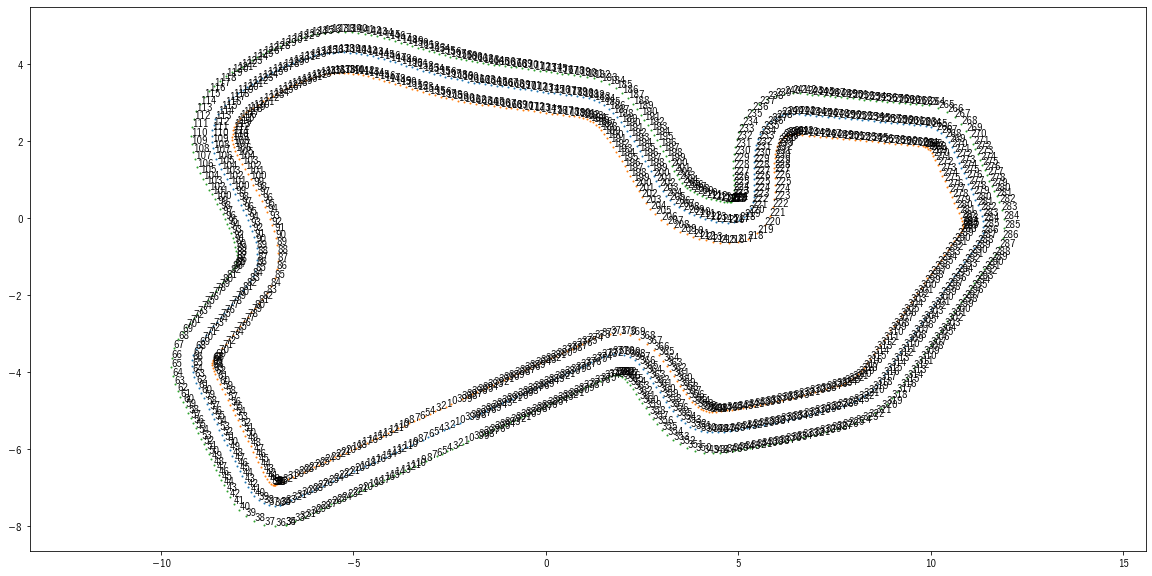

In [12]:
# Plot the results
fig, ax = plt.subplots(figsize=(20,10))
plot_points(ax, waypoints[:-1,0:2])
plot_points(ax, waypoints[:-1,2:4])
plot_points(ax, waypoints[:-1,4:6])
ax.axis('equal')
plt.show()

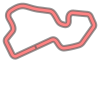

In [13]:
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

road_poly

In [14]:
# rescale waypoints to centimeter scale

center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

# ヘルパー関数

In [15]:
def plot_track(df, track_size=(500, 800), x_offset=0, y_offset=0):
    '''
    Each track may have a diff track size, 
    For reinvent track, use track_size=(500, 800)
    Tokyo, track_size=(700, 1000)
    x_offset, y_offset is used to convert to the 0,0 coordinate system
    '''
    track = np.zeros(track_size) # lets magnify the track by *100
    for index, row in df.iterrows():
        x = int(row["x"] + x_offset)
        y = int(row["y"] + y_offset)
        reward = row["reward"]
        track[y, x] = reward
        
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(111)
    print_border(ax, center_line, inner_border, outer_border)
    return track

In [16]:
def plot_top_laps(sorted_idx, n_laps=5):
    fig = plt.figure(n_laps, figsize=(12, 30))
    for i in range(n_laps):
        idx = sorted_idx[i]
        
        episode_data = episode_map[idx]
        
        ax = fig.add_subplot(n_laps,1,i+1)
        
        line = LineString(center_line)
        plot_coords(ax, line)
        plot_line(ax, line)
        
        line = LineString(inner_border)
        plot_coords(ax, line)
        plot_line(ax, line)

        line = LineString(outer_border)
        plot_coords(ax, line)
        plot_line(ax, line)


        for idx in range(1, len(episode_data)-1):
            x1,y1,action,reward,angle,speed = episode_data[idx]
            car_x2, car_y2 = x1 - 0.02, y1
            plt.plot([x1, car_x2], [y1, car_y2], 'b.')
        
    return fig

## トレーニングログの読み込み

In [17]:
TRAINING_ITERATION = 20

In [18]:
df = pd.read_csv(merged_simtrace_path)
iteration_arr = np.arange(math.ceil(df.episode.max()/TRAINING_ITERATION)+1) * TRAINING_ITERATION
df['iteration'] = np.digitize(df.episode, iteration_arr)
df = df.rename(columns={"X": "x", "Y": "y", "tstamp": "timestamp"})
df.head()

,episode,steps,x,y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,timestamp,episode_status,iteration
0,0,1.0,-2.370337,-5.367573,-155.320284,0.0,0.666667,4,1.0,False,True,0.232686,1,60.057236,1.600065e+09,in_progress,1
1,0,2.0,-2.378108,-5.370960,-155.372891,-30.0,0.333333,0,1.0,False,True,0.246799,1,60.057236,1.600065e+09,in_progress,1
2,0,3.0,-2.383029,-5.373252,-155.353759,0.0,0.666667,4,1.0,False,True,0.255836,1,60.057236,1.600065e+09,in_progress,1
3,0,4.0,-2.409104,-5.384149,-155.622225,-30.0,0.333333,0,1.0,False,True,0.302864,1,60.057236,1.600065e+09,in_progress,1
4,0,5.0,-2.427537,-5.390873,-155.957054,30.0,0.333333,6,1.0,False,True,0.335428,1,60.057236,1.600065e+09,in_progress,1


In [19]:
df['y'].min(), df['x'].max()

(-8.096498614581124, 12.138227872643778)

In [20]:
# Normalize the rewards to a 0-1 scale

from sklearn.preprocessing import  MinMaxScaler
min_max_scaler = MinMaxScaler()
scaled_vals = min_max_scaler.fit_transform(df['reward'].values.reshape(df['reward'].values.shape[0], 1))
df['reward'] = pd.DataFrame(scaled_vals.squeeze())

In [21]:
df['reward'].min(), df['reward'].max()

(0.0, 1.0)

## イテレーションごとの報酬をプロットする

このグラフは、各エピソード内の平均報酬と標準偏差を理解するのに便利です。

Number of episodes =  199


Text(0.5, 0, 'Episode')

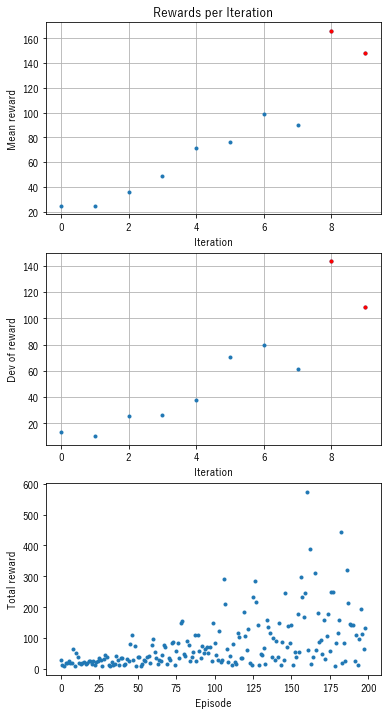

In [22]:
REWARD_THRESHOLD = 100

# reward graph per episode
min_episodes = np.min(df['episode'])
max_episodes = np.max(df['episode'])
print('Number of episodes = ', max_episodes)

total_reward_per_episode = list()
for epi in range(min_episodes, max_episodes):
    df_slice = df[df['episode'] == epi]
    total_reward_per_episode.append(np.sum(df_slice['reward']))

average_reward_per_iteration = list()
deviation_reward_per_iteration = list()

buffer_rew = list()
for val in total_reward_per_episode:
    buffer_rew.append(val)

    if len(buffer_rew) == TRAINING_ITERATION - 1:
        average_reward_per_iteration.append(np.mean(buffer_rew))
        deviation_reward_per_iteration.append(np.std(buffer_rew))
        # reset
        buffer_rew = list()


fig = plt.figure(figsize=(6, 12))
ax = fig.add_subplot(311)
ax.plot(np.arange(len(average_reward_per_iteration)), average_reward_per_iteration, '.')
ax.set_title('Rewards per Iteration')
ax.set_ylabel('Mean reward')
ax.set_xlabel('Iteration')

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD :
        ax.plot(rr, average_reward_per_iteration[rr], 'r.')

plt.grid(True)

ax = fig.add_subplot(312)
ax.plot(np.arange(len(deviation_reward_per_iteration)), deviation_reward_per_iteration, '.')

ax.set_ylabel('Dev of reward')
ax.set_xlabel('Iteration')
plt.grid(True)

for rr in range(len(average_reward_per_iteration)):
    if average_reward_per_iteration[rr] >= REWARD_THRESHOLD:
        ax.plot(rr, deviation_reward_per_iteration[rr], 'r.')


ax = fig.add_subplot(313)
ax.plot(np.arange(len(total_reward_per_episode)), total_reward_per_episode, '.')
ax.set_ylabel('Total reward')
ax.set_xlabel('Episode')

## 報酬関数の報酬分布を分析する

In [23]:
# add y_offset to bring everything to the positive axis
center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

x_offset = int(df['x'].min())
if x_offset > 0: # if positive, just keep it the same
    x_offset = 0
x_offset = abs(x_offset)

y_offset = int(df['y'].min())
if y_offset > 0: # if positive, just keep it the same
    y_offset = 0
y_offset = abs(y_offset)

inner_border[:,0] = inner_border[:,0] + x_offset
inner_border[:,1] = inner_border[:,1] + y_offset
center_line[:,0] = center_line[:,0] + x_offset
center_line[:,1] = center_line[:,1] + y_offset
outer_border[:,0] = outer_border[:,0] + x_offset
outer_border[:,1] = outer_border[:,1] + y_offset

In [24]:
#NOTE: For the Tokyo track use this dimentions

#track = plot_track(df, track_size=(700, 1000), x_offset=0, y_offset=y_offset)
#plt.title("Reward distribution for all actions ")
#im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower")

In [25]:
print("Min x-axis {}; Max x-axis {}".format(np.min(df['x']), np.max(df['x'])))
print("Min y-axis {}; Max y-axis {}".format(np.min(df['y']), np.max(df['y'])))

Min x-axis -9.864501629427613; Max x-axis 12.138227872643778
Min y-axis -8.096498614581124; Max y-axis 5.061071849671532


In [26]:
height = int(df['y'].max() - df['y'].min())
width = int(df['x'].max() - df['x'].min())
print(height, width)

13 22


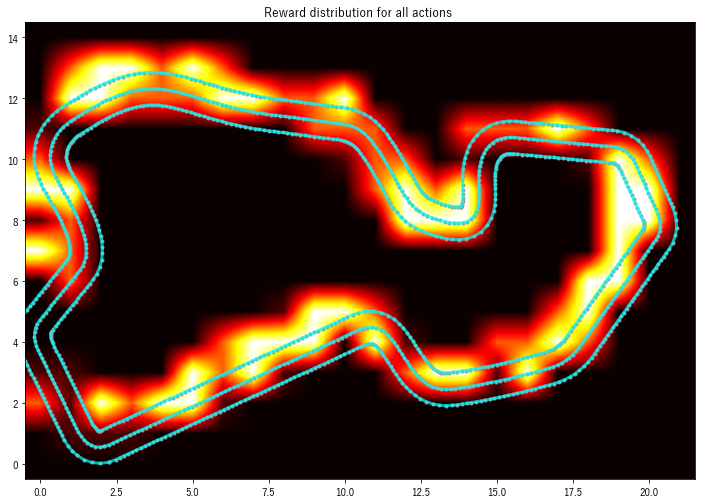

In [27]:
# track = plot_track(df, track_size=(10, 10), x_offset=0, y_offset=0)
track = plot_track(df, track_size=(height + 2, width), x_offset=x_offset, y_offset=x_offset)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower")

### 特定のイテレーションをプロットする

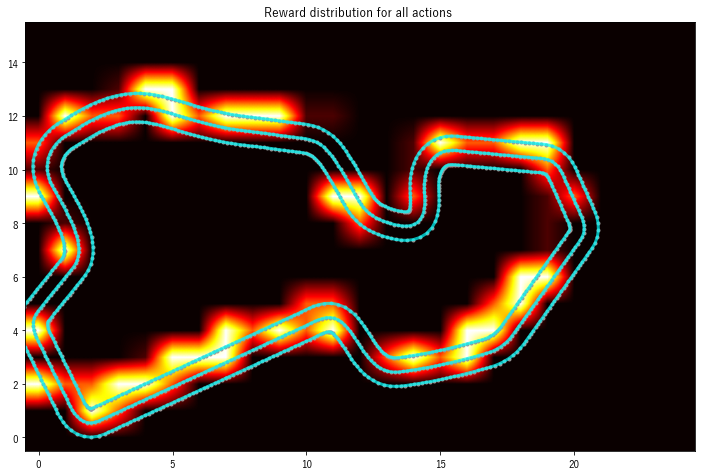

In [28]:
iteration_id = 4
# track = plot_track(df[df['iteration'] == iteration_id], track_size=(11, 20), x_offset=0, y_offset=0)
track = plot_track(df[df['iteration'] == iteration_id],  track_size=(height + 3, width + 3), x_offset=x_offset, y_offset=x_offset)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

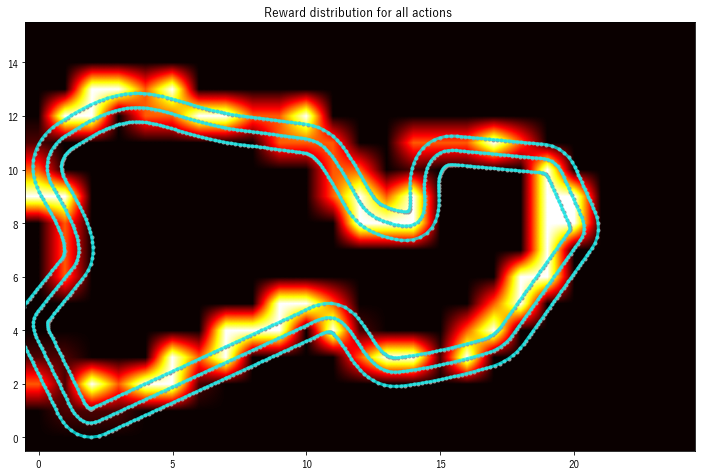

In [29]:
iteration_id = 10
# track = plot_track(df[df['iteration'] == iteration_id], track_size=(11, 20), x_offset=0, y_offset=0)
track = plot_track(df[df['iteration'] == iteration_id], track_size=(height + 3, width + 3), x_offset=x_offset, y_offset=x_offset)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

### トップリワードのイテレーションのために取られたパス

注：単一のエピソードでは、車は複数の周回を回ることができ、車が1000ステップを完了したときにエピソードが終了します。

In [30]:
# reset waypoints to centimeter scale

waypoints = get_track_waypoints("Belille") ### re:invent track
waypoints.shape

center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

The top 3 highest reward episodes are [160, 182, 162]


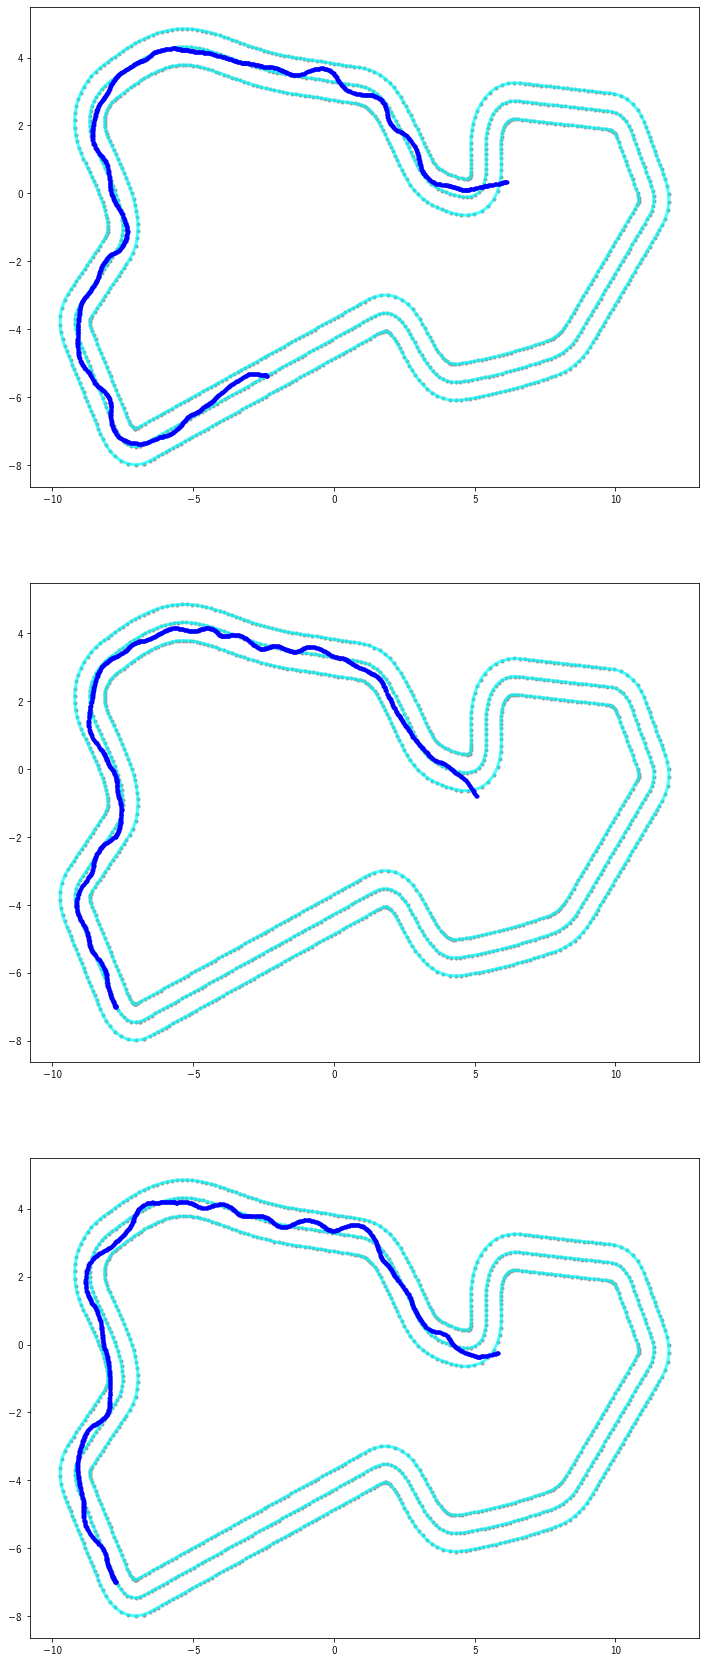

In [31]:
action_map, episode_map, sorted_idx = episode_parser(df)    
fig = plot_top_laps(sorted_idx[:], 3)
print("The top 3 highest reward episodes are {}".format(sorted_idx[:3]))

### 特定のエピソードで取られた経路

In [32]:
## Evaluation RUN
def plot_episode_run(df, E):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    print_border(ax, center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

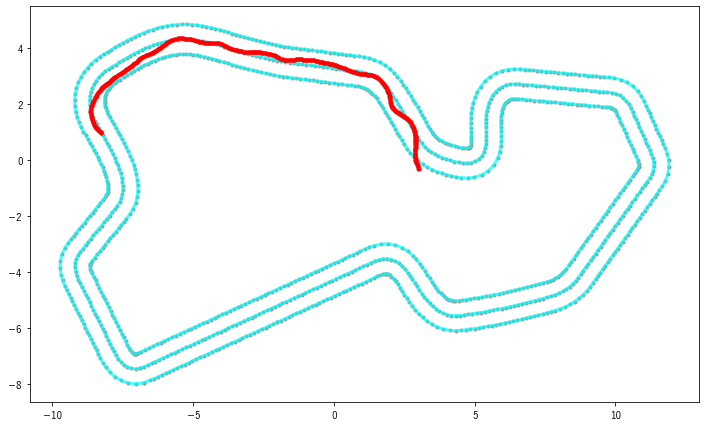

In [33]:
plot_episode_run(df, E=125) # arbitrary episode

### 特定のイテレーションで使用されるパス

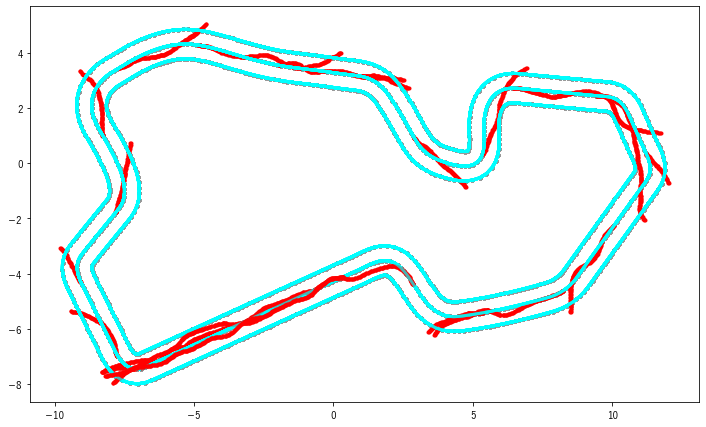

In [34]:
iteration_id = 4

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df, E=i)

## イテレーションごとのアクションの内訳と、各ターンのアクション分布のヒストグラム

このプロットは、モデルが任意の反復に対して取るアクションを理解するのに便利です。

**注：これは現在のところ reinvent track でのみサポートされています。**

Number of steps in iteration= 1882


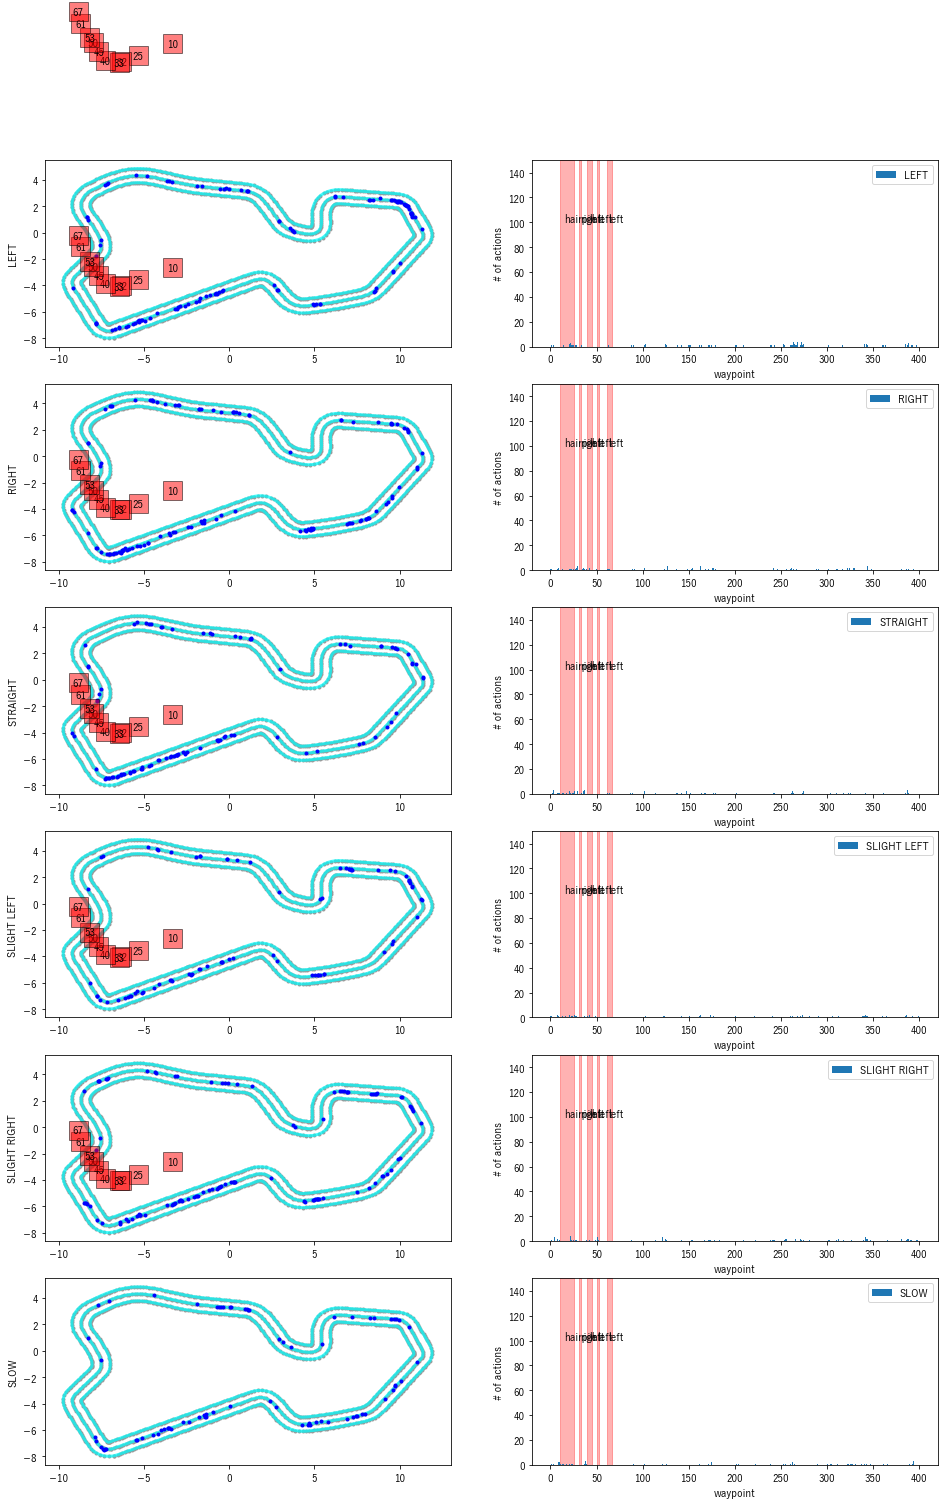

In [35]:
fig = plt.figure(figsize=(16, 24))
iterations_downselect = [iteration_id] ## Lets pick the iteratons with the highest rewards

# Track Segment Labels
action_names = ['LEFT', 'RIGHT', 'STRAIGHT', 'SLIGHT LEFT', 'SLIGHT RIGHT', 'SLOW']
vert_lines = [10,25,32,33,40,45,50,53,61,67]
track_segments = [(15, 100, 'hairpin'),
                  (32, 100, 'right'),
                  (42, 100, 'left'),
                  (51, 100, 'left'),
                  (63, 100, 'left')]

segment_x = np.array([15, 32, 42, 51, 63])
segment_y = np.array([0, 0, 0, 0, 0])

segment_xerr = np.array([[5, 1, 2, 1, 2], [10, 1, 3, 2, 4]])
segment_yerr = np.array([[0, 0, 0, 0, 0], [150, 150, 150, 150, 150]])

wpts_array = center_line 

for iter_num in iterations_downselect:

    # Slice the data frame to get all episodes in that iteration
    df_iter = df[(iter_num == df['iteration'])]
    n_steps_in_iter = len(df_iter)
    print('Number of steps in iteration=', n_steps_in_iter)

    th = 0.8
    for idx in range(len(action_names)):
        ax = fig.add_subplot(6, 2, 2*idx+1)
        print_border(ax, center_line, inner_border, outer_border) 
            
        df_slice = df_iter[df_iter['reward'] >= th]
        df_slice = df_slice[df_slice['action'] == idx]

        ax.plot(df_slice['x'], df_slice['y'], 'b.')

        for idWp in vert_lines:
            ax.text(wpts_array[idWp][0], wpts_array[idWp][1]+20, str(idWp), bbox=dict(facecolor='red', alpha=0.5))

        #ax.set_title(str(log_name_id) + '-' + str(iter_num) + ' w rew >= '+str(th))
        ax.set_ylabel(action_names[idx])

        # calculate action way point distribution
        action_waypoint_distribution = list()
        for idWp in range(len(wpts_array)):
            action_waypoint_distribution.append(len(df_slice[df_slice['closest_waypoint'] == idWp]))

        ax = fig.add_subplot(6, 2, 2 * idx + 2)

        # Call function to create error boxes
        _ = make_error_boxes(ax, segment_x, segment_y, segment_xerr, segment_yerr)

        for tt in range(len(track_segments)):
            ax.text(track_segments[tt][0], track_segments[tt][1], track_segments[tt][2])

        ax.bar(np.arange(len(wpts_array)), action_waypoint_distribution)
        ax.set_xlabel('waypoint')
        ax.set_ylabel('# of actions')
        ax.legend([action_names[idx]])
        ax.set_ylim((0, 150))

ヘアピンターンを分析してみましょう。このモデルは、他のアクションよりも、わずかな左とストレートを好むことがわかり、わずかな右と右のアクションの頻度は、それに比べて非常に低いことがわかります。要するに、このモデルはヘアピンターンをうまく行っているようです。

## 評価の実行分析を行う

評価の実行をデバッグしたり、ラップを分析したりする

In [36]:
merged_simtrace_path = "./logs/deepracer-{}.csv".format("evaluation")

In [37]:
merge_csv_files(merged_simtrace_path, tmp="./logs/evaluation-simtrace")
!tail -n 3 $merged_simtrace_path

4,405.0,-7.029228704817078,3.0885758535413195,9.187938712509414,-30.0,0.6666666666666666,1,0.001,False,False,30.846784205795817,124,60.05723639247675,1600071133.1533012,in_progress
4,406.0,-6.9808636242415165,3.081999984888723,5.828762067770836,30.0,1.0,8,0.001,False,False,30.91111645197592,124,60.05723639247675,1600071133.2234898,in_progress
4,407.0,-6.916401192724015,3.0696190944400596,1.583056076610734,30.0,0.3333333333333333,6,0.001,True,False,30.993856392787116,125,60.05723639247675,1600071133.2850995,off_track


In [38]:
eval_df = pd.read_csv(merged_simtrace_path)
iteration_arr = np.arange(math.ceil(eval_df.episode.max()/TRAINING_ITERATION)+1) * TRAINING_ITERATION
eval_df['iteration'] = np.digitize(eval_df.episode, iteration_arr)
eval_df = eval_df.rename(columns={"X": "x", "Y": "y", "tstamp": "timestamp"})
eval_df.head()

,episode,steps,x,y,yaw,steer,throttle,action,reward,done,all_wheels_on_track,progress,closest_waypoint,track_len,timestamp,episode_status,iteration
0,0,1.0,-1.916052,-5.158876,-155.313452,0.0,0.333333,3,1.0,False,True,-0.599736,398,60.057236,1.600071e+09,in_progress,1
1,0,2.0,-1.918158,-5.159713,-155.348900,0.0,0.333333,3,1.0,False,True,-0.595967,398,60.057236,1.600071e+09,in_progress,1
2,0,3.0,-1.926697,-5.163719,-155.331840,0.0,0.333333,3,1.0,False,True,-0.580262,398,60.057236,1.600071e+09,in_progress,1
3,0,4.0,-1.946951,-5.172724,-155.403851,0.0,0.333333,3,1.0,False,True,-0.543358,398,60.057236,1.600071e+09,in_progress,1
4,0,5.0,-1.963770,-5.180632,-155.351231,30.0,0.333333,6,1.0,False,True,-0.512413,398,60.057236,1.600071e+09,in_progress,1


## Grid World 分析
エピソードごとにパスに沿った車の速度を把握します。これは、車が速く走らない可能性があるトラックの部分をデバッグするのに役立ちます。そのため、報酬関数を改善するためのヒントが得られます。

In [39]:
# reset waypoints to centimeter scale

waypoints = get_track_waypoints("Albert") ### re:invent track
waypoints.shape

center_line = waypoints[:,0:2] 
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

y_offset = int(df['y'].min())
if y_offset > 0: # if positive, just keep it the same
    y_offset = 0
y_offset = abs(y_offset)

x_offset = int(df['x'].min())
if x_offset > 0: # if positive, just keep it the same
    x_offset = 0
x_offset = abs(x_offset)

inner_border[:,0] = inner_border[:,0] + x_offset
inner_border[:,1] = inner_border[:,1] + y_offset
center_line[:,0] = center_line[:,0] + x_offset
center_line[:,1] = center_line[:,1] + y_offset
outer_border[:,0] = outer_border[:,0] + x_offset
outer_border[:,1] = outer_border[:,1] + y_offset

Episode #0 
39 29
Outer polygon length = 218.95 (meters)
Inner polygon length = 192.15 (meters)
Distance, lap time = 0.10 (meters), 17.68 (sec)
Average throttle, velocity = 0.55 (Gazebo), 0.01 (meters/sec)
###############################################################


Episode #1 
39 29
Outer polygon length = 218.95 (meters)
Inner polygon length = 192.15 (meters)
Distance, lap time = 0.10 (meters), 15.76 (sec)
Average throttle, velocity = 0.61 (Gazebo), 0.01 (meters/sec)
###############################################################


Episode #2 
39 29
Outer polygon length = 218.95 (meters)
Inner polygon length = 192.15 (meters)
Distance, lap time = 0.06 (meters), 9.77 (sec)
Average throttle, velocity = 0.59 (Gazebo), 0.01 (meters/sec)
###############################################################




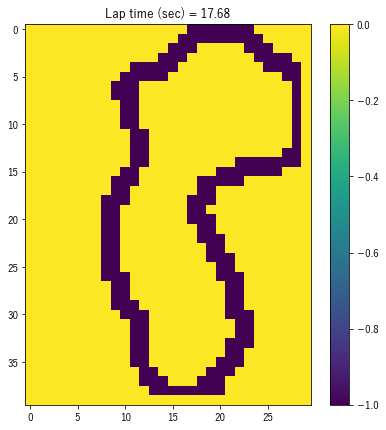

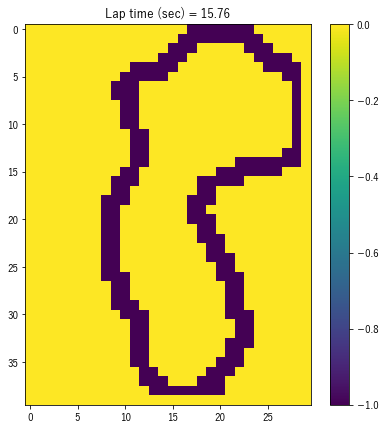

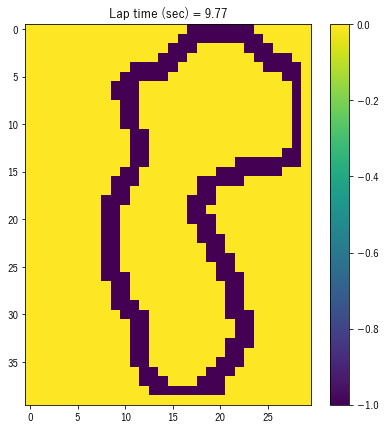

In [40]:
N_EPISODES = 3
for e in range(N_EPISODES):
    print ("Episode #%s " %e)
    episode_df = eval_df[eval_df['episode'] == e]
    plot_grid_world(episode_df, inner_border, outer_border, scale=0.5)
    print ("###############################################################\n\n")

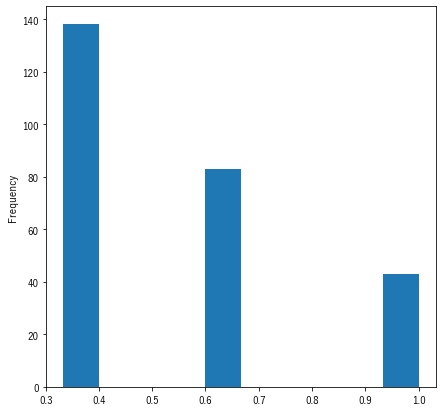

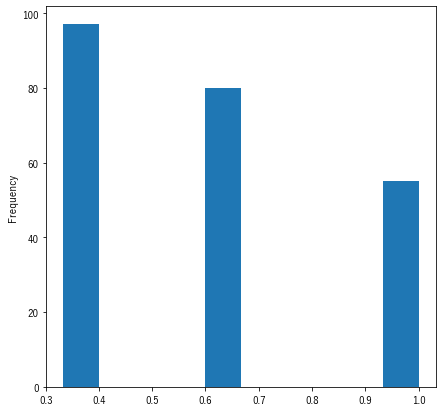

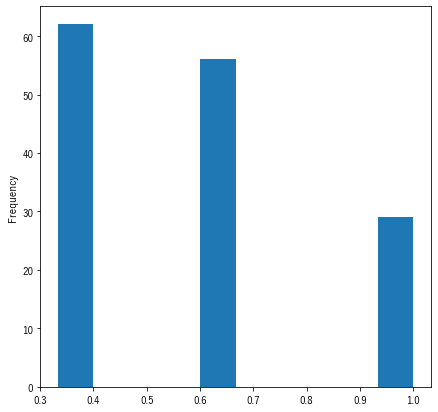

In [41]:
for e in range(N_EPISODES):
    episode_df = eval_df[eval_df['episode'] == e]
    if len(episode_df) > 0:
        fig = plt.figure(figsize=(7,7))
        episode_df['throttle'].plot.hist()